In [1]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
import copy
import time
import pandas as pd 
import pickle

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

pyro.set_rng_seed(0)
plt.rcParams['figure.dpi'] = 100

/Applications/anaconda3/envs/AVSGP/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# General configuration

In [2]:
M = 20
T = 90

# Some parameters
num_steps_init = 200
num_steps_online = 1

lamb_ = np.exp(np.log(0.1)/T) 
print(lamb_)


0.9747402255566063


# Data generation

In [3]:
# We predict next day with the previous week

# https://archive.ics.uci.edu/ml/datasets/Online+Retail
def generate_data1():

    file_name = '../data/OnlineRetail.xls'
    df = pd.read_excel(file_name)
    df.head()
    
    df['PriceTot'] = df ['Quantity']*df['UnitPrice']
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date
    df = df[['InvoiceDate','PriceTot']]
    data = df.groupby(['InvoiceDate']).sum().reset_index()
    
    data = data.sort_values(by='InvoiceDate')
    
    #Reshape X and Y by weeks
    X = data.PriceTot.values
    N_prev_days = 8
    X_week = X[:-(N_prev_days+1)][:,np.newaxis]
    for i in range(1,N_prev_days-1):
        X_week = np.concatenate((X_week, X[i:-(N_prev_days+1-i)][:,np.newaxis]), axis =1)
    i = N_prev_days-1
    X_week = np.concatenate((X_week, X[i:-2][:,np.newaxis]), axis =1)

    X = X_week[:,:7]
    Y = X_week[:,7]
    
    #Rescale X, Y
    scale_factor =  10000
    X = X /scale_factor
    Y = Y/scale_factor

    # One month for model initialization
    days_init = 90
    X_init = torch.Tensor(X[:days_init])
    y_init = torch.Tensor(Y[:days_init]) 
    X_t = torch.Tensor(X[days_init:-1])
    y_t = torch.Tensor(Y[days_init:-1])

    return X_init, y_init, X_t, y_t 

In [4]:
def generate_data2():
    #https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series/data?select=train.csv
    store_sales = pd.read_csv(
         '../data/StoreSales.csv',
        usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
        dtype={
            'store_nbr': 'category',
            'family': 'category',
            'sales': 'float32',
            'onpromotion': 'uint32',
        },
        parse_dates=['date']
    )
    store_sales['date'] = store_sales.date.dt.to_period('D')
    store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

    family_sales = (
    store_sales
    .groupby(['date'])
    .mean()
    )

    X = family_sales['sales'].values
    #outliers
    pos = np.array([   0,  364,  728, 1092, 1457])
    X[pos] = X[pos-1]
    
    N_prev_days = 8
    X_week = X[:-(N_prev_days+1)][:,np.newaxis]
    for i in range(1,N_prev_days-1):
        X_week = np.concatenate((X_week, X[i:-(N_prev_days+1-i)][:,np.newaxis]), axis =1)
    i = N_prev_days-1
    X_week = np.concatenate((X_week, X[i:-2][:,np.newaxis]), axis =1)

    X = X_week[:,:7]
    Y = X_week[:,7]
    
    #Rescale X, Y
    scale_factor =  np.std(X)
    X = X /scale_factor
    Y = Y/scale_factor

    # One month for model initialization
    days_init = 90
    X_init = torch.Tensor(X[:days_init])
    y_init = torch.Tensor(Y[:days_init]) 
    X_t = torch.Tensor(X[days_init:-1])
    y_t = torch.Tensor(Y[days_init:-1])

    return X_init, y_init, X_t, y_t 



In [5]:
def generate_data(num):
    if num == -1:
        name = 'OR'
        X_init, y_init, X_t, y_t  = generate_data1()
    elif num == 0:
        name = 'SS'
        X_init, y_init, X_t, y_t  = generate_data2()
    return name, X_init, y_init, X_t, y_t 

In [6]:
num=0
name, X_init, y_init, X_t, y_t  = generate_data(num)

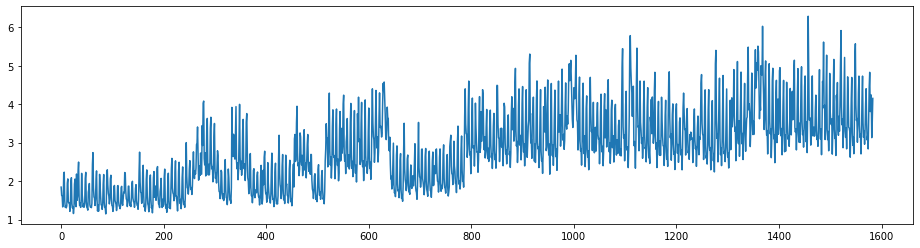

In [7]:
fig = plt.figure(figsize=(16,4))
plt.plot(X_t[:,0])


# Persistence Baseline

We predict the next day load with the load of the input day at the same time

In [8]:
print('Persistence BASELINE')

Persistence BASELINE


In [9]:
for num in [-1,0]:
    
    name, X_init, y_init, X_t, y_t = generate_data(num)

    y_pred = X_t[:,-1]
    mean_pred_baseline1 = y_pred
    MSE_baseline1 = (y_pred-y_t)**2

    data = {'mse':MSE_baseline1,
            'mean':y_pred}

    with open('../results_review2/'+name+'_Persistence.pickle', 'wb') as handle:
      pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


# ADAPTIVE MODELS

In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
import os
import sys
import inspect

parentdir = "../lib/"
sys.path.insert(0, parentdir) 

from AdaptiveSparseGPRegression import AdaptiveSparseGPRegression 

## Fast-AGP: Adaptive SVGP without inference

Model parameters are NOT updated (only inducing points)

In [12]:
print('Fast-AGP: Adaptive SVGP without inference')

Fast-AGP: Adaptive SVGP without inference


In [17]:
for num in [-1,0]:
    print(num)
    
    mse_pred_iter = []
    mean_pred_iter = []
    std_pred_iter = []
    IC_95_iter = []
    n_inducing_iter = []
    train_time_iter = []
    test_time_iter =[]

    name, X_init, y_init, X_t, y_t = generate_data(num)


    # initialize pyro
    pyro.clear_param_store()

    # initialize the inducing inputs with the last training samples 
    inducing_points = X_init[-2*M::2,:]
    Xu = torch.Tensor(copy.copy(inducing_points))

    # initialize the kernel
    kernel = gp.kernels.RBF(input_dim=X_init.shape[1]) 

    ###################################
    # Define the model
    osgpr = AdaptiveSparseGPRegression(X_init, y_init, kernel, Xu=Xu, lamb =lamb_, jitter=1.0e-4)
    # Initialize the model
    osgpr.batch_update(num_steps = num_steps_init)
    ####################################   

    mse_pred = []
    mean_pred = []
    std_pred = []
    IC_95 = []
    n_inducing =[] 
    test_time = 0
    train_time = 0

    n_inducing = [osgpr.Xu.shape[0]]

    for t, (x, y) in enumerate(zip(X_t, y_t)):

      X_new = X_t[t:t+1]
      y_new = y_t[t:t+1]

      start = time.process_time()
      # Compute test error predicting next sample
      with torch.no_grad():
        pred, cov = osgpr(X_new, noiseless=False)
      test_time += (time.process_time()-start) 

      mean_pred.append(pred.numpy())

      mse = (pred-y_new)**2
      mse_pred.append(mse.numpy())

      std = torch.sqrt(cov)
      std_pred.append(std.numpy())
      IC_95.append((torch.abs(y_new-pred)<2*std).numpy())

      #####################################
      # Update model
      start = time.process_time()
      loss = osgpr.fast_online_update(X_new, y_new, L = T, M = M, perc_th = 1e-4)
      train_time += (time.process_time()-start) 
      ######################################
      n_inducing.append(osgpr.Xu.shape[0])

    # Save variables
    mse_pred_iter.append(mse_pred)
    std_pred_iter.append(std_pred)
    mean_pred_iter.append(mean_pred)
    IC_95_iter.append(IC_95)
    n_inducing_iter.append(n_inducing)
    train_time_iter.append(train_time)
    test_time_iter.append(test_time)

    data = {'mse':mse_pred_iter,
        'std':std_pred_iter,
        'mean':mean_pred_iter,
        'IC_95':IC_95_iter,
        'n_inducing':n_inducing_iter,
        'train_time':train_time_iter,
        'test_time':test_time_iter}
   
    with open('../results/'+name+'_Fast-AGP.pickle', 'wb') as handle:
      pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

-1
0


## AGP: Adaptive SVGP with inference

We apply inference over all model parameters

In [17]:
print('AGP: Adaptive SVGP with inference')

AGP: Adaptive SVGP with inference


In [20]:
for num in [-1,0]:
    print(num)
    name, X_init, y_init, X_t, y_t = generate_data(num)

    mse_pred_iter = []
    std_pred_iter = []
    mean_pred_iter = []
    IC_95_iter = []
    n_inducing_iter = []
    train_time_iter = []
    test_time_iter =[]

   
    # initialize the kernel and model
    pyro.clear_param_store()
    kernel = gp.kernels.RBF(input_dim=X_init.shape[1])

    # initialize the inducing inputs in interval [0,1] 
    inducing_points = X_init[-2*M::2,:]
    Xu = torch.Tensor(copy.copy(inducing_points))

    ###################################
    # Define the model
    osgpr = AdaptiveSparseGPRegression(X_init, y_init, kernel, Xu=Xu, lamb =lamb_, jitter=1.0e-4)
    # Initialize the model
    osgpr.batch_update(num_steps = num_steps_init)
    ####################################   


    mse_pred = []
    std_pred = []
    mean_pred = []
    IC_95 = []
    n_inducing =[]
    test_time = 0
    train_time = 0

    variances=[osgpr.kernel.variance.item()]
    noises=[osgpr.noise.item()]
    lengthscales = [osgpr.kernel.lengthscale.item()]
    n_inducing = [osgpr.Xu.shape[0]]

    for t, (x, y) in enumerate(zip(X_t, y_t)):

      X_new = X_t[t:t+1]
      y_new = y_t[t:t+1]

      start = time.process_time()
      # Compute test error predicting next sample
      with torch.no_grad():
        pred, cov = osgpr(X_new, noiseless=False)
      test_time += (time.process_time()-start) 

      mean_pred.append(pred.numpy())

      mse = (pred-y_new)**2
      mse_pred.append(mse.numpy())

      std = torch.sqrt(cov)
      std_pred.append(std.numpy())
      IC_95.append((torch.abs(y_new-pred)<2*std).numpy())
    
      #####################################
      # Update model
      start = time.process_time()
      loss = osgpr.online_update(X_new, y_new, L = T, M = M, num_steps = num_steps_online, perc_th = 1e-4)
      train_time += (time.process_time()-start) 
      ######################################
    
      variances.append(osgpr.kernel.variance.item())
      noises.append(osgpr.noise.item())
      lengthscales.append(osgpr.kernel.lengthscale.item())
      n_inducing.append(osgpr.Xu.shape[0])


    # Save variables
    mse_pred_iter.append(mse_pred)
    mean_pred_iter.append(mean_pred)
    std_pred_iter.append(std_pred)
    IC_95_iter.append(IC_95)
    n_inducing_iter.append(n_inducing)
    train_time_iter.append(train_time)
    test_time_iter.append(test_time)

    data = {'mse':mse_pred_iter,
        'std':std_pred_iter,
        'mean':mean_pred_iter,
        'IC_95':IC_95_iter,
        'n_inducing':n_inducing_iter,
        'train_time':train_time_iter,
        'test_time':test_time_iter}


    with open('../results/'+name+'_AGP.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

-1
0


## Adaptive VSGP with VSI

In [19]:
print('AGP-VSI: Adaptive VSGP with VSI')

AGP-VSI: Adaptive VSGP with VSI


In [20]:
from AdaptiveELBO import adaptive_elbo

In [21]:
for num in [-1,0]:
    print(num)
    name, X_init, y_init, X_t, y_t = generate_data(num)
    
    mse_pred_iter = []
    mean_pred_iter = []
    std_pred_iter = []
    IC_95_iter = []
    train_time_iter = []
    test_time_iter =[]


    # initialize the kernel and model
    pyro.clear_param_store()
    kernel = gp.kernels.RBF(input_dim=X_init.shape[1], variance=torch.tensor(1.0), lengthscale=torch.tensor(1.))

    # initialize the inducing inputs in interval [0,1] 
    #inducing_points = X_init[M:,:]
    inducing_points = X_init[-2*M::2,:]
    Xu = torch.Tensor(copy.copy(inducing_points))

    likelihood = gp.likelihoods.Gaussian()

    forget_factor =  torch.flip(torch.cumprod(lamb_*torch.ones_like(y_init), dim=0), [0])
    forget_factor = torch.cat((forget_factor[1:],torch.tensor([1.0])))

    # turn on "whiten" flag for more stable optimization
    vsgp = gp.models.VariationalSparseGP(
      X_init, y_init, kernel, Xu=Xu, likelihood=likelihood, whiten=True, jitter=1e-3
    )

    optimizer = torch.optim.Adam(vsgp.parameters(), lr=0.05)
    loss_fn = adaptive_elbo

    for i in range(num_steps_init):
      optimizer.zero_grad()
      loss = loss_fn(vsgp.model, vsgp.guide, forget_factor)
      loss.backward()
      optimizer.step()

    mse_pred = []
    mean_pred = []
    std_pred = []
    IC_95 = []
    test_time = 0
    train_time = 0


    X_window = X_init
    y_window = y_init 

    for t, (x, y) in enumerate(zip(X_t, y_t)):

      X_new = X_t[t:t+1]
      y_new = y_t[t:t+1]

      start = time.process_time()
      # Compute test error predicting next sample
      with torch.no_grad():
        pred, cov = vsgp(X_new)
      test_time += (time.process_time()-start) 

      mean_pred.append(pred.numpy())

      mse = (pred-y_new)**2
      mse_pred.append(mse.numpy())

      cov = cov + vsgp.likelihood.variance
      std = torch.sqrt(cov)
      std_pred.append(std.detach().numpy())
      IC_95.append((torch.abs(y_new-pred)<2*std).numpy())

      start = time.process_time()
      # Update model with new data
      X_window = torch.cat((X_window[1:], X_new))
      y_window = torch.cat((y_window[1:], y_new))

      forget_factor = torch.cat((lamb_*forget_factor[1:],torch.tensor([1.0]))) 

      vsgp.set_data(X_window, y_window)

      for i in range(50*num_steps_online):
          optimizer.zero_grad()
          loss = loss_fn(vsgp.model, vsgp.guide, forget_factor)
          loss.backward()
          optimizer.step()
      train_time += (time.process_time()-start) 


      # Save variables
      mse_pred_iter.append(mse_pred)
      std_pred_iter.append(std_pred)
      mean_pred_iter.append(mean_pred)
      IC_95_iter.append(IC_95)
      train_time_iter.append(train_time)
      test_time_iter.append(test_time)

    data = {'mse':mse_pred_iter,
        'std':std_pred_iter,
        'mean':mean_pred_iter,
        'IC_95':IC_95_iter,
        'train_time':train_time_iter,
        'test_time':test_time_iter}

    with open('../results/'+name+'_AGP-VSI.pickle', 'wb') as handle:
      pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

-1
0


# BASELINES

## Training a GP per iteration with a sliding data window

In [22]:
print('w-SVGP: A windowed SVGP')

w-SVGP: A windowed SVGP


In [23]:
for num in [-1,0]:
    print(num)
    name, X_init, y_init, X_t, y_t = generate_data(num)
    
    mse_pred_iter = []
    mean_pred_iter = []
    std_pred_iter = []
    IC_95_iter = []
    train_time_iter = []
    test_time_iter =[]

    # initialize the inducing inputs in interval [0,1] 
    inducing_points = X_init[-2*M::2,:]
    Xu = torch.Tensor(copy.copy(inducing_points))

    # initialize the kernel, likelihood, and model
    pyro.clear_param_store()
    kernel = gp.kernels.RBF(input_dim=X_init.shape[1])

    likelihood = gp.likelihoods.Gaussian()
    # turn on "whiten" flag for more stable optimization
    vsgp = gp.models.VariationalSparseGP(
      X_init, y_init, kernel, Xu=Xu, likelihood=likelihood, whiten=True, jitter=1e-3
    )

    # Train the first model
    optimizer = torch.optim.Adam(vsgp.parameters(), lr=0.05)
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

    for i in range(num_steps_init):
      optimizer.zero_grad()
      loss = loss_fn(vsgp.model, vsgp.guide)
      loss.backward()
      optimizer.step()

    mse_pred = []
    mean_pred = []
    std_pred = []
    IC_95 = []
    test_time = 0
    train_time = 0


    X_window = X_init
    y_window = y_init 

    for t, (x, y) in enumerate(zip(X_t, y_t)):

      X_new = X_t[t:t+1]
      y_new = y_t[t:t+1]

      start = time.process_time()
      # Compute test error predicting next sample
      with torch.no_grad():
        pred, cov = vsgp(X_new)
      test_time += (time.process_time()-start) 

      mean_pred.append(pred.numpy())

      mse = (pred-y_new)**2
      mse_pred.append(mse.numpy())

      cov = cov + vsgp.likelihood.variance
      std = torch.sqrt(cov)
      std_pred.append(std.detach().numpy())
      IC_95.append((torch.abs(y_new-pred)<2*std).numpy())

      start = time.process_time()
      # Update model with new data
      X_window = torch.cat((X_window[1:], X_new))
      y_window = torch.cat((y_window[1:], y_new))

      vsgp.set_data(X_window, y_window)

      for i in range(50*num_steps_online):
          optimizer.zero_grad()
          loss = loss_fn(vsgp.model, vsgp.guide)
          loss.backward()
          optimizer.step()
      train_time += (time.process_time()-start) 

      # Save variables
      mse_pred_iter.append(mse_pred)
      std_pred_iter.append(std_pred)
      mean_pred_iter.append(mean_pred)
      IC_95_iter.append(IC_95)
      train_time_iter.append(train_time)
      test_time_iter.append(test_time)

    data = {'mse':mse_pred_iter,
        'std':std_pred_iter,
        'mean':mean_pred_iter,
        'IC_95':IC_95_iter,
        'train_time':train_time_iter,
        'test_time':test_time_iter}

    with open('../results/'+name+'_w-SVGP.pickle', 'wb') as handle:
      pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

-1
0


## Online SGP

This is the model proposed in:

https://arxiv.org/pdf/1705.07131.pdf

https://github.com/thangbui/streaming_sparse_gp/blob/b46e6e4a9257937f7ca26ac06099f5365c8b50d8/code/osgpr.py

But here, we used the pythorch iomplementation included in

https://github.com/wjmaddox/online_gp



In [24]:
import sys
sys.path.append('../experiments/regression/')

sys.path.append('/export/usuarios01/vanessa/online_gp/')

from copy import deepcopy

import math

import gpytorch
from gpytorch import mlls
from online_gp import models



In [25]:
print('OSGP: Online SGP ')

OSGP: Online SGP 


In [ ]:
for num in [-1,0]:
    print(num)
    name, X_init, y_init, X_t, y_t = generate_data(num)
    
    mse_pred_iter = []
    mean_pred_iter = []
    std_pred_iter = []
    IC_95_iter = []
    train_time_iter = []
    test_time_iter =[]

    # initialize pyro
    pyro.clear_param_store()

    init_x= X_init
    init_y= y_init[:,None]
    X = X_t
    Y = y_t[:,None]

    # Initialize the model
    covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    # initialize the inducing inputs with the last training samples 
    inducing_points =copy.copy(init_x[-2*M::2,:])

    osgpr_model = models.StreamingSGPR(inducing_points, learn_inducing_locations=True, 
                                covar_module=covar_module, num_data=init_x.size(0), jitter=1e-3)

    # Training a initial GP as starting point

    elbo = mlls.VariationalELBO(osgpr_model.likelihood, osgpr_model, num_data=init_x.size(0))
    mll = mlls.ExactMarginalLogLikelihood(osgpr_model.likelihood, osgpr_model)
    trainable_params = [
    dict(params=osgpr_model.likelihood.parameters(), lr=1e-1),
    dict(params=osgpr_model.covar_module.parameters(), lr=1e-1),
    dict(params=osgpr_model.variational_strategy.inducing_points, lr=1e-2),
    dict(params=osgpr_model.variational_strategy._variational_distribution.parameters(), lr=1e-2)
    ]
    optimizer = torch.optim.Adam(trainable_params)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 400, 1e-4)

    osgpr_model.train()
    records = []
    for i in range(num_steps_init):
        optimizer.zero_grad()
        train_dist = osgpr_model(init_x)
        loss = -elbo(train_dist, init_y.squeeze(-1)).sum()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

    osgpr_model.eval()
    osgpr_model = osgpr_model.get_fantasy_model(init_x, init_y, resample_ratio=0)

    mse_pred = []
    mean_pred = []
    std_pred = []
    IC_95 = []
    test_time = 0
    train_time = 0

    chunk_size = T

    for t, (x, y) in enumerate(zip(X, Y)):

        X_new =  X[t:t+1]
        y_new = Y[t:t+1]

        # Compute test error predicting next sample
        start = time.process_time()  
        with torch.no_grad():
            pred, cov = osgpr_model.predict(X_new)
        test_time += (time.process_time()-start) 

        mean_pred.append(pred.numpy())

        mse = (pred-y_new)**2
        mse_pred.append(mse.numpy())

        std = torch.sqrt(cov)
        std_pred.append(std.detach().numpy())
        IC_95.append((torch.abs(y_new-pred)<2*std).numpy())

        start = time.process_time()
        elbo = models.StreamingSGPRBound(osgpr_model)
        trainable_params = [
          dict(params=osgpr_model.likelihood.parameters(), lr=1e-1),
          dict(params=osgpr_model.covar_module.parameters(), lr=1e-1),
          dict(params=osgpr_model.variational_strategy.inducing_points, lr=1e-2),
        ]
        optimizer = torch.optim.Adam(trainable_params)

        for _ in range(num_steps_online):
            optimizer.zero_grad()
            loss = -elbo(x.view(-1, 1).T, y.view(-1, 1))
            loss.backward()
            optimizer.step()

        osgpr_model = osgpr_model.get_fantasy_model(x.view(-1, 1).T, y.view(-1, 1), resample_ratio=0)
        train_time += (time.process_time()-start) 

    # Save variables
    mse_pred_iter.append(mse_pred)
    std_pred_iter.append(std_pred)
    mean_pred_iter.append(mean_pred)
    IC_95_iter.append(IC_95)
    train_time_iter.append(train_time)
    test_time_iter.append(test_time)



    data = {'mse':mse_pred_iter,
        'std':std_pred_iter,
        'mean':mean_pred_iter,
        'IC_95':IC_95_iter,
        'train_time':train_time_iter,
        'test_time':test_time_iter}

    with open('../results/'+name+'_OSGP.pickle', 'wb') as handle:
      pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


## Kernel Interpolation for Scalable Online Gaussian Processes (WISKI)


This is the WISKI (Woodbury Inversion with SKI) model from the paper:

Kernel Interpolation for Scalable Online Gaussian Processes

by Samuel Stanton, Wesley J. Maddox, Ian Delbridge, Andrew Gordon Wilson


The code is avaliable from https://github.com/wjmaddox/online_gp


In [27]:
from online_gp.models.stems import Identity, LinearStem
from online_gp import models
import gpytorch

In [28]:
print('Baseline: WISKI')

Baseline: WISKI


In [ ]:
for num in [-1,0]:
    print(num)
    name, X_init, y_init, X_t, y_t = generate_data(num)
    
    mse_pred_iter = []
    mean_pred_iter = []
    std_pred_iter = []
    IC_95_iter = []
    train_time_iter = []
    test_time_iter =[]

    online_lr = 1e-1

    init_x= X_init
    init_y= y_init[:,None]
    X = X_t
    Y = y_t[:,None]

    # Initialize the model
    stem = LinearStem(input_dim=init_x.size(-1), feature_dim=2) 

    covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    wiski_model = models.OnlineSKIRegression(stem, init_x, init_y, lr=1e-1, grid_size=M, grid_bound=1., covar_module=covar_module)
    wiski_model.fit(init_x, init_y, num_steps_init)  # pretrain model

    mse_pred = []
    mean_pred = []
    std_pred = []
    IC_95 = []
    test_time = 0
    train_time = 0

    wiski_model.set_lr(1e-2)

    for t, (x, y) in enumerate(zip(X, Y)):
      X_new =  X[t:t+1]
      y_new = Y[t:t+1]

      # Compute test error predicting next sample
      start = time.process_time()  
      with torch.no_grad():
        pred, cov = wiski_model.predict(X_new)
      test_time += (time.process_time()-start) 

      mean_pred.append(pred.numpy())

      mse = (pred-y_new)**2
      mse_pred.append(mse.numpy())

      std = torch.sqrt(cov)
      std_pred.append(std.detach().numpy())
      IC_95.append((torch.abs(y_new-pred)<2*std).numpy())

      start = time.process_time() 
      wiski_model.update(x, y)
      train_time += (time.process_time()-start) 

    # Save variables
    mse_pred_iter.append(mse_pred)
    std_pred_iter.append(std_pred)
    mean_pred_iter.append(mean_pred)
    IC_95_iter.append(IC_95)
    train_time_iter.append(train_time)
    test_time_iter.append(test_time)

    data = {'mse':mse_pred_iter,
        'std':std_pred_iter,
        'mean':mean_pred_iter,
        'IC_95':IC_95_iter,
        'train_time':train_time_iter,
        'test_time':test_time_iter}

    with open('../results/'+name+'_WISKI.pickle', 'wb') as handle:
      pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# RESULTADOS

In [6]:
import pickle
import matplotlib.pyplot as plt
import numpy as np


In [13]:
print('& & Persistance & w-SVGP & OSGP & WISKI & AGP-VSI & Fast-AGP & AGP \\\\ \\hline  \\hline')

avg_Dummy={}
avg_w_SVGP = {}
avg_WISKI = {}
avg_OSGP = {}
avg_AGP_VSI = {}
avg_fast_AGP = {}
avg_AGP = {}

for num in [-1,0]:
    dataset, cat, name = get_dataset_info(num)


    with open('../results/'+name+'_Persistence.pickle', 'rb') as handle:
        data_Dummy = pickle.load(handle)

    with open('../results/'+name+'_Fast-AGP.pickle', 'rb') as handle:
        data_fast_AGP = pickle.load(handle)

    with open('../results/'+name+'_AGP.pickle', 'rb') as handle:
        data_AGP = pickle.load(handle)

    with open('../results/'+name+'_AGP-VSI.pickle', 'rb') as handle:
        data_AGP_VSI = pickle.load(handle)

    with open('../results/'+name+'_w-SVGP.pickle', 'rb') as handle:
        data_w_SVGP = pickle.load(handle)

    with open('../results/'+name+'_OSGP.pickle', 'rb') as handle:
        data_OSGP = pickle.load(handle)

    with open('../results/'+name+'_WISKI.pickle', 'rb') as handle:
        data_WISKI = pickle.load(handle)

    for field in ['mse', 'IC_95', 'train_time']:
        
        
        if num == -1:
            avg_Dummy[field] = []
            avg_w_SVGP[field] = []
            avg_WISKI[field] = []
            avg_OSGP[field] = [] 
            avg_AGP_VSI[field] = []
            avg_fast_AGP[field] = []
            avg_AGP[field] = []
        
        avg_w_SVGP[field].append(np.mean(data_w_SVGP[field]))
        avg_WISKI[field].append(np.mean(data_WISKI[field]))
        avg_OSGP[field].append(np.mean(data_OSGP[field]))
        avg_AGP_VSI[field].append(np.mean(data_AGP_VSI[field]))
        avg_fast_AGP[field].append(np.mean(data_fast_AGP[field]))
        avg_AGP[field].append(np.mean(data_AGP[field]))
        

        if field == 'mse':
            print(' & MSE & %2.4f & %2.4f & %2.4f &  %2.4f & %2.4f & %2.4f & %2.4f  \\\\' %(np.mean(data_Dummy[field].numpy()),   np.mean(data_w_SVGP[field]), np.mean(data_OSGP[field]), np.mean(data_WISKI[field]),np.mean(data_AGP_VSI[field]), np.mean(data_fast_AGP[field]), np.mean(data_AGP[field])))
        if field == 'IC_95':
            print(' %s & IC 95 & -- & %2.2f & %2.2f &  %2.2f & %2.2f & %2.2f & %2.2f  \\\\' %(name, 100*np.mean(data_w_SVGP[field]), 100*np.mean(data_OSGP[field]),  100*np.mean(data_WISKI[field]), 100*np.mean(data_AGP_VSI[field]), 100*np.mean(data_fast_AGP[field]), 100*np.mean(data_AGP[field])))
        if field == 'train_time':
            print(' & Tr. Time & -- & %2.1f & %2.1f & %2.1f & %2.1f & %2.1f & %2.1f  \\\\ \\hline' %(np.mean(data_w_SVGP[field]), np.mean(data_OSGP[field]), np.mean(data_WISKI[field]),np.mean(data_AGP_VSI[field]), np.mean(data_fast_AGP[field]), np.mean(data_AGP[field])))


for field in ['mse', 'IC_95', 'train_time']:
    if field == 'mse':
        print(' & MSE & %2.4f & %2.4f & %2.4f &  %2.4f & %2.4f & %2.4f & %2.4f  \\\\' %( np.mean(np.array(avg_Dummy[field])),   np.mean(np.array(avg_w_SVGP[field])), np.mean(np.array(avg_OSGP[field])), np.mean(np.array(avg_WISKI[field])), np.mean(np.array(avg_AGP_VSI[field])), np.mean(np.array(avg_fast_AGP[field])), np.mean(np.array(avg_AGP[field]))))
    if field == 'IC_95':
        print('Average & IC 95 & -- & %2.2f & %2.2f &  %2.2f & %2.2f & %2.2f & %2.2f  \\\\' %( 100*np.mean(np.array(avg_w_SVGP[field])), 100*np.mean(np.array(avg_OSGP[field])),  100*np.mean(np.array(avg_WISKI[field])), 100*np.mean(np.array(avg_AGP_VSI[field])), 100*np.mean(np.array(avg_fast_AGP[field])), 100*np.mean(np.array(avg_AGP[field]))))
    if field == 'train_time':
        print(' & Tr. Time & -- & %2.1f & %2.1f & %2.1f & %2.1f & %2.1f & %2.1f  \\\\ \\hline' %(  np.mean(np.array(avg_w_SVGP[field])), np.mean(np.array(avg_OSGP[field])), np.mean(np.array(avg_WISKI[field])), np.mean(np.array(avg_AGP_VSI[field])), np.mean(np.array(avg_fast_AGP[field])), np.mean(np.array(avg_AGP[field]))))


& & Persistance & w-SVGP & OSGP & WISKI & AGP-VSI & Fast-AGP & AGP \\ \hline  \hline
 & MSE & 0.4106 & 0.1744 & 400737.7500 &  0.3877 & 0.1966 & 0.1868 & 0.2180  \\
 SS & IC 95 & -- & 87.63 & 17.68 &  83.21 & 90.47 & 84.28 & 95.45  \\
 & Tr. Time & -- & 1911.6 & 245.4 & 226.7 & 1833.5 & 39.6 & 297.7  \\ \hline
 & MSE & 3.9486 & 2.4789 & 2.5190 &  2.0593 & 2.2916 & 2.1920 & 2.2394  \\
 OR & IC 95 & -- & 84.39 & 89.76 &  89.27 & 87.32 & 93.17 & 94.15  \\
 & Tr. Time & -- & 240.6 & 30.5 & 29.3 & 232.0 & 3.0 & 20.7  \\ \hline
 & MSE & nan & 1.3266 & 200370.1406 &  1.2235 & 1.2441 & 1.1894 & 1.2287  \\
Average & IC 95 & -- & 86.01 & 53.72 &  86.24 & 88.89 & 88.73 & 94.80  \\
 & Tr. Time & -- & 1076.1 & 138.0 & 128.0 & 1032.7 & 21.3 & 159.2  \\ \hline
